<a href="https://colab.research.google.com/github/SidDsloth/Concept-Tutorials-Redone/blob/master/Reinforcement-Learning/RL_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import random
import math

In [0]:
MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.0001
GAMMA = 0.99
BATCH_SIZE = 50

In [0]:
class Model:
  def __init__(self,num_states,num_actions,batch_size):
    self._num_states=num_states
    self._num_actions=num_actions
    self._batch_size=batch_size
    
    #define placeholders
    self._states=None
    self._actions=None
    
    #op operations
    self._logits=None
    self._optimier=None
    self._var_init=None
    
    #noe model setup
    self._define_model()
    
  def _define_model(self):
    self._states=tf.placeholder(shape=[None,self._num_states],dtype=tf.float32)
    self._q_s_a=tf.placeholder(shape=[None,self._num_actions],dtype=tf.float32)
    #creating fc hidden layers
    fc1=tf.layers.dense(self._states,50,activation=tf.nn.relu)
    fc2=tf.layers.dense(fc1,50,activation=tf.nn.relu)
    self._logits=tf.layers.dense(fc2,self._num_actions)
    loss=tf.losses.mean_squared_error(self._q_s_a,self._logits)
    self._optimizer=tf.train.AdamOptimizer().minimize(loss)
    self._var_init=tf.global_variables_initializer()
    
  def predict_one(self,state,sess):
    return sess.run(self._logits,feed_dict={self._states:state.reshape(1,self.num_states)})
  
  def predict_batch(self,states,sess):
    return sess.run(self._logits,feed_dict={self._states:states})
  
  def train_batch(self,sess,x_batch,y_batch):
    return sess.run(self._optimizer,feed_dict={self._states:x_batch,self._q_s_a:y_batch})

  @property
  def num_states(self):
    return self._num_states
  
  @property
  def num_actions(self):
    return self._num_actions
  
  @property
  def batch_size(self):
    return self._batch_size

  @property
  def var_init(self):
    return self._var_init


Initialisation fn. Pass in model number of states in env ie 2 number of actions ie 3 and batch size. fn sets up variables. After that _define_model() is called which sets up the model structure. _states and _q_s_a hold state data and Q(s,a). 1st dim of placeholder NONE to adapt to batch of data fed to model. _logits-Dense layer, network learns Q value all possible real nos. 
predict_one returns o/p of network. Called whenever action selection has to be done.
predict_batch predicts batch of o/p perform batch eval of Q(s,a) and Q(s',a').
train_batch takes batch training step of network.

In [0]:
class Memory:
  def __init__(self,max_memory):
    self._max_memory=max_memory
    self._samples=[]
    
  def add_sample(self,sample):
    self._samples.append(sample)
    if len(self._samples)>self._max_memory:
      self._samples.pop(0)
  def sample(self,no_samples):
    if no_samples>len(self._samples):
      return random.sample(self._samples,len(self._samples))
    else:
      return random.sample(self._samples,no_samples)

Class stores results of actions. Max Mem controls max no of (state,action,reward,next_state) tuple the _samples list holds. 
Add_sample takes ind tuple ^ and appends to _samples list. Then memory check done.
sample returns random selection of no_samples in length.

In [0]:
class GameRunner:
  def __init__(self,sess,model,env,memory,max_eps,min_eps,decay,render=False):
    self._sess=sess
    self._env=env
    self._model=model
    self._memory=memory
    self._render=render
    self._max_eps=max_eps
    self._min_eps=min_eps
    self._decay=decay
    self._eps=self._max_eps
    self._steps=0
    self._reward_store=[]
    self._max_x_store=[]
    
  def run(self):
    state=self._env.reset()
    tot_reward=0
    max_x=-100
    while True:
      if self._render:
        self._env.render()
      action=self._choose_action(state)
      next_state,reward,done,info=self._env.step(action)
      if next_state[0]>=0.1:
        reward+=10
      elif next_state[0]>=.25:
        reward+=20
      elif next_state[0]>=.5:
        reward+=100
        
      if next_state[0]>max_x:
        max_x=next_state[0]
      # If game complete set next_state=None
      if done:
        next_state=None
      
      self._memory.add_sample((state,action,reward,next_state))
      self._replay()
      #exp decay of eps
      self._steps+=1
      #self._eps=MIN_EPSILON+(MAX_EPSILON_MIN_EPSILON)\*math.exp(-LAMBDA*self._steps)
      self._eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON)\
                                 * math.exp(-LAMBDA * self._steps)
      #move agent to next state to accumulate reward
      state=next_state
      tot_reward+=reward
      
      #If game done break loop
      if done:
        self._reward_store.append(tot_reward)
        self._max_x_store.append(max_x)
        break
    print("Step {}, Total reward: {}, Eps: {}".format(self._steps, tot_reward, self._eps))
  
  def _choose_action(self,state):
    if random.random()<self._eps:
      return random.randint(0,self._model.num_actions-1)
    else:
      return np.argmax(self._model.predict_one(state,self._sess))
    
  def _replay(self):
    batch=self._memory.sample(self._model.batch_size)
    states=np.array([val[0] for val in batch])
    next_states=np.array([(np.zeros(self._model.num_states)
                          if val[3] is None else val[3]) for val in batch])
    #predict q
    q_s_a=self._model.predict_batch(states,self._sess)
    #predict new q for gamma*max new q
    q_s_a_d=self._model.predict_batch(next_states,self._sess)
    #setup training arrays
    x=np.zeros((len(batch),self._model.num_states))
    y=np.zeros((len(batch),self._model.num_actions))
    for i,b in enumerate(batch):
      state,action,reward,next_state=b[0],b[1],b[2],b[3]
      #current q values for all state actions
      current_q=q_s_a[i]
      #update the q value for action
      if next_state is None:
        #game completed
        current_q[action]=reward
      else:
        current_q[action]=reward+GAMMA*np.amax(q_s_a_d[i])
      x[i]=state
      y[i]=current_q
    self._model.train_batch(self._sess,x,y)
    
  @property
  def reward_store(self):
    return self._reward_store
      
  @property
  def max_x_store(self):
    return self._max_x_store    

Internal variable initialization. Args- tf sess, nn model, gym env, mem class instance. Epsilon values. Render refers to screen.

Run()- env reset. Action decided by _choose_action(state). Agent takes action by gym com step(). Manual variation in reward system done. Maximum x displacement stored. Data stored in memory class. Replay/training step of class takes place. Epsilon value decayed. Reward stored.

_choose_action()- eps greedy+q policy. If rand no < _eps value action random chosen or else predicted by nn. _pre_one takes 1 state i/p and o/p Q value of each possible action highest selected.

_replay()- Get random batch of data from mem. Q= r+YmaxQ, next_state predict Q(s',a'). If next_state extracted is None it corresponds to vector of zeros. 
Batch of q and Q' got from states and next_states . x and y training created. Extract mem values for batch. State and current q loaded then _train_batch() called! 

Episode 1 of 300
Step 200, Total reward: -200.0, Eps: 0.9803966865736877
Step 400, Total reward: -200.0, Eps: 0.9611815447608
Step 600, Total reward: -200.0, Eps: 0.9423468882484062
Step 800, Total reward: -200.0, Eps: 0.9238851829227694
Step 1000, Total reward: -200.0, Eps: 0.9057890438555999
Step 1200, Total reward: -200.0, Eps: 0.888051232349986
Step 1400, Total reward: -200.0, Eps: 0.8706646530448178
Step 1600, Total reward: -200.0, Eps: 0.8536223510765493
Step 1800, Total reward: -200.0, Eps: 0.8369175092971592
Step 2000, Total reward: -200.0, Eps: 0.820543445547202
Episode 11 of 300
Step 2200, Total reward: -200.0, Eps: 0.8044936099828537
Step 2400, Total reward: -200.0, Eps: 0.7887615824558878
Step 2600, Total reward: -200.0, Eps: 0.7733410699455306
Step 2800, Total reward: -200.0, Eps: 0.7582259040411682
Step 3000, Total reward: -200.0, Eps: 0.7434100384749007
Step 3200, Total reward: -200.0, Eps: 0.7288875467029541
Step 3400, Total reward: -200.0, Eps: 0.7146526195349836
Step 

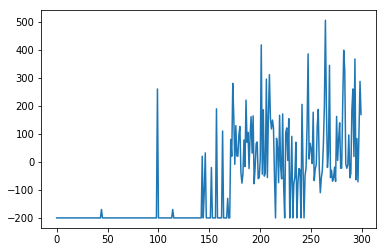

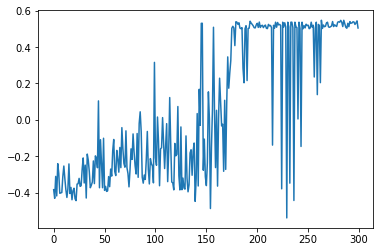

In [0]:
if __name__=="__main__":
  env_name='MountainCar-v0'
  env=gym.make(env_name)
  
  num_states=env.env.observation_space.shape[0]
  num_actions=env.env.action_space.n
  
  model=Model(num_states,num_actions,BATCH_SIZE)
  mem=Memory(50000)
  
  with tf.Session() as sess:
    sess.run(model.var_init)
    gr=GameRunner(sess,model,env,mem,MAX_EPSILON,MIN_EPSILON,LAMBDA)
    num_episodes=300
    cnt=0
    while cnt<num_episodes:
      if cnt%10==0:
        print('Episode {} of {}'.format(cnt+1, num_episodes))
      gr.run()
      cnt+=1
    plt.plot(gr.reward_store)
    plt.show()
    plt.close("all")
    plt.plot(gr.max_x_store)
    plt.show()    

Create a gym env. num_action/states got. batch of 50 and tot_sam of mem 50k. Gamerunner called after basic tf sess creation. Each episode run()  method called. In the end plot drawn of rewards and x value vs episodes.